# In-Depth: Decision Trees and Random Forests

Ранее мы подробно рассмотрели простой генеративный классификатор (наивный байесовский; см. [Подробно: Наивная байесовская классификация] (05.05-Naive-Bayes.ipynb)) и мощный дискриминационный классификатор (машины опорных векторов; см. [Подробно: Машины опорных векторов] (05.07-Support-Vector-Machines.ipynb)).
Здесь мы рассмотрим мотивацию другого мощного алгоритма — непараметрического алгоритма, называемого *случайными лесами*.
Случайные леса являются примером метода *ансамбля*, что означает, что он основан на агрегировании результатов ансамбля более простых оценок.
Несколько неожиданный результат с такими ансамблевыми методами состоит в том, что сумма может быть больше, чем части: то есть большинство голосов среди нескольких оценщиков может оказаться лучше, чем любой из отдельных оценщиков, участвующих в голосовании!
Мы увидим примеры этого в следующих разделах.
Начнем со стандартного импорта:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## Motivating Random Forests: Decision Trees

Случайные леса являются примером *обучаемого ансамбля*, построенного на деревьях решений.
По этой причине мы начнем с обсуждения самих деревьев решений.

Деревья решений — это чрезвычайно интуитивный способ классификации или маркировки объектов: вы просто задаете серию вопросов, разработанных для того, чтобы сосредоточиться на классификации.
Например, если вы хотите построить дерево решений для классификации животных, с которыми вы сталкиваетесь во время похода, вы можете построить дерево, показанное здесь:

![](figures/05.08-decision-tree.png)
[figure source in Appendix](06.00-Figure-Code.ipynb#Decision-Tree-Example)

Бинарное разбиение делает это чрезвычайно эффективным: в хорошо построенном дереве каждый вопрос сокращает количество вариантов примерно вдвое, очень быстро сужая варианты даже среди большого количества классов.
Хитрость, конечно же, заключается в том, чтобы решить, какие вопросы задавать на каждом этапе.
В реализациях деревьев решений с помощью машинного обучения вопросы обычно принимают форму разделения данных по оси: то есть каждый узел в дереве разбивает данные на две группы, используя значение отсечки в пределах одного из признаков.
Давайте теперь посмотрим на пример этого.

### Создание дерева решений

Рассмотрим следующие двумерные данные, которые имеют одну из четырех меток класса:

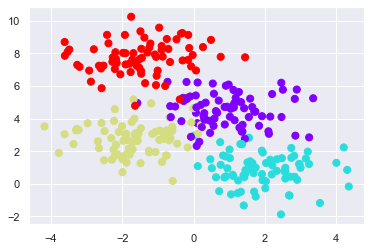

In [2]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

Простое дерево решений, построенное на этих данных, будет итеративно разбивать данные по той или иной оси в соответствии с некоторым количественным критерием и на каждом уровне присваивать метку новому региону в соответствии с большинством голосов внутри него.
На этом рисунке представлена визуализация первых четырех уровней классификатора дерева решений для этих данных:

![](figures/05.08-decision-tree-levels.png)
[figure source in Appendix](06.00-Figure-Code.ipynb#Decision-Tree-Levels)

Обратите внимание, что после первого разбиения каждая точка верхней ветви остается неизменной, поэтому нет необходимости дополнительно разбивать эту ветвь.
За исключением узлов, которые содержат все элементы одного цвета, на каждом уровне *каждая* область снова разделяется по одному из двух признаков.

Этот процесс подгонки дерева решений к нашим данным можно выполнить в Scikit-Learn с помощью оценщика DecisionTreeClassifier:

In [3]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X, y)

Давайте напишем быструю служебную функцию, которая поможет нам визуализировать вывод классификатора:

In [4]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

Теперь мы можем изучить, как выглядит классификация дерева решений:

C:\Users\BIASPA~1\AppData\Local\Temp/ipykernel_18152/520376207.py:20: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3,


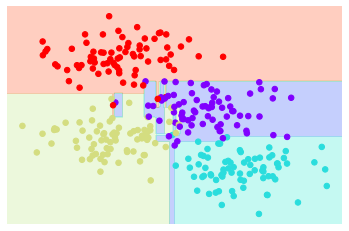

In [9]:
visualize_classifier(DecisionTreeClassifier(max_depth=10), X, y)

Если вы используете эту записную книжку в режиме реального времени, вы можете использовать вспомогательный сценарий, включенный в [Онлайн-приложение] (06.00-Figure-Code.ipynb#Helper-Code), чтобы вызвать интерактивную визуализацию процесса построения дерева решений:

In [12]:
# helpers_05_08 is found in the online appendix
import helpers_05_08
helpers_05_08.plot_tree_interactive(X, y);

interactive(children=(Dropdown(description='depth', index=1, options=(1, 5), value=5), Output()), _dom_classes…

Обратите внимание, что по мере увеличения глубины мы получаем области классификации очень странной формы; например, на глубине пять между желтой и синей областями находится высокая и узкая фиолетовая область.
Понятно, что это не столько результат истинного, внутреннего распределения данных, сколько результат конкретной выборки или свойств шума данных.
То есть это дерево решений даже на пяти уровнях глубины явно перекрывает наши данные.

### Деревья решений и переобучение

Такая чрезмерная подгонка оказывается общим свойством деревьев решений: очень легко слишком углубиться в дерево и, таким образом, подобрать детали конкретных данных, а не общие свойства распределений, из которых они взяты.
Другой способ увидеть это переоснащение — посмотреть на модели, обученные на разных подмножествах данных — например, на этом рисунке мы обучаем два разных дерева, каждое на половине исходных данных

![](05.08-decision-tree-overfitting.png)
[figure source in Appendix](06.00-Figure-Code.ipynb#Decision-Tree-Overfitting)

Понятно, что в некоторых местах два дерева дают согласованные результаты (например, в четырех углах), в то время как в других местах два дерева дают очень разные классификации (например, в областях между любыми двумя кластерами).
Ключевым наблюдением является то, что несоответствия, как правило, возникают там, где классификация менее определенна, и, таким образом, используя информацию из *обоих* этих деревьев, мы могли бы получить лучший результат!

Если вы используете эту записную книжку в режиме реального времени, следующая функция позволит вам в интерактивном режиме отображать подгонки деревьев, обученных на случайном подмножестве данных:

In [13]:
# helpers_05_08 is found in the online appendix
import helpers_05_08
helpers_05_08.randomized_tree_interactive(X, y)

interactive(children=(Dropdown(description='random_state', options=(0, 100), value=0), Output()), _dom_classes…

Точно так же, как использование информации из двух деревьев улучшает наши результаты, мы можем ожидать, что использование информации из многих деревьев улучшит наши результаты еще больше.

## Ансамбли оценщиков: случайные леса

Это представление о том, что несколько оценок переобучения можно комбинировать, чтобы уменьшить эффект этого переобучения, лежит в основе ансамблевого метода, называемого *мешками*.
Бэггинг использует ансамбль (возможно, пакет) параллельных оценок, каждая из которых переопределяет данные и усредняет результаты, чтобы найти лучшую классификацию.
Ансамбль рандомизированных деревьев решений известен как «случайный лес».

Этот тип классификации пакетов можно выполнить вручную с помощью метаоценщика Scikit-Learn BaggingClassifier, как показано здесь:

C:\Users\BIASPA~1\AppData\Local\Temp/ipykernel_18152/520376207.py:20: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3,


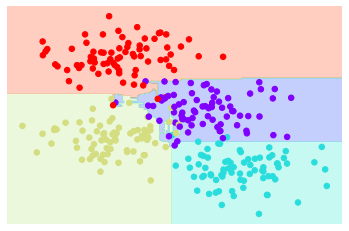

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8,
                        random_state=1)

bag.fit(X, y)
visualize_classifier(bag, X, y)

В этом примере мы рандомизировали данные, подбирая для каждой оценки случайное подмножество из 80% тренировочных баллов.
На практике деревья решений более эффективно рандомизируются за счет добавления некоторой стохастичности в выбор разбиений: таким образом, все данные каждый раз вносят вклад в подбор, но результаты подбора по-прежнему имеют желаемую случайность.
Например, при определении того, по какому признаку разделить, рандомизированное дерево может выбрать один из нескольких лучших признаков.
Вы можете прочитать более подробную техническую информацию об этих стратегиях рандомизации в [документации Scikit-Learn] (http://scikit-learn.org/stable/modules/ensemble.html#forest) и ссылках внутри.

В Scikit-Learn такой оптимизированный ансамбль рандомизированных деревьев решений реализован в оценщике RandomForestClassifier, который автоматически выполняет всю рандомизацию.
Все, что вам нужно сделать, это выбрать ряд оценщиков, и он очень быстро (параллельно, при желании) подгонит ансамбль деревьев:

C:\Users\BIASPA~1\AppData\Local\Temp/ipykernel_18152/520376207.py:20: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3,


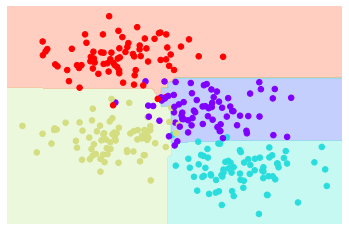

In [17]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0,max_depth=2)
visualize_classifier(model, X, y);

Мы видим, что, усредняя более 100 случайно возмущенных моделей, мы получаем общую модель, которая намного ближе к нашему интуитивному представлению о том, как должно быть разделено пространство параметров.

## Случайная лесная регрессия

В предыдущем разделе мы рассмотрели случайные леса в контексте классификации.
Случайные леса также можно заставить работать в случае регрессии (то есть непрерывных, а не категориальных переменных). Для этого используется оценщик RandomForestRegressor, и его синтаксис очень похож на то, что мы видели ранее.

Рассмотрим следующие данные, полученные из комбинации быстрых и медленных колебаний:

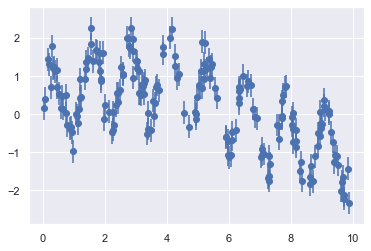

In [29]:
rng = np.random.RandomState(42)
x = 10 * rng.rand(200)

def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x))

    return slow_oscillation + fast_oscillation + noise

y = model(x)
plt.errorbar(x, y, 0.3, fmt='o');

Используя регрессор случайного леса, мы можем найти кривую наилучшего соответствия следующим образом:

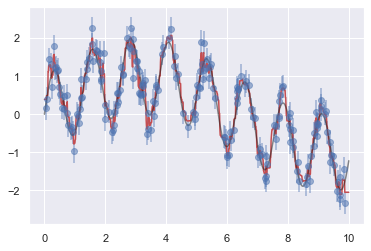

In [19]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(200)
forest.fit(x[:, None], y)

xfit = np.linspace(0, 10, 1000)
yfit = forest.predict(xfit[:, None])
ytrue = model(xfit, sigma=0)

plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5);

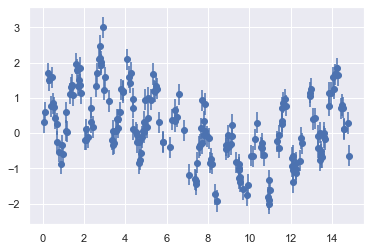

In [23]:
rng = np.random.RandomState(42)
x_n = 15 * rng.rand(200)

def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x))

    return slow_oscillation + fast_oscillation + noise

y_n = model(x_n)
plt.errorbar(x_n, y_n, 0.3, fmt='o');

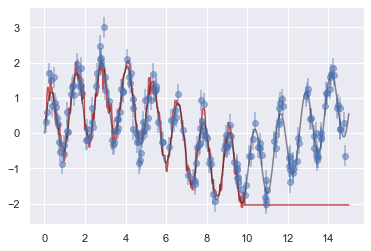

In [32]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(200)
forest.fit(x[:, None], y)

xfit = np.linspace(0, 15, 1000)
yfit = forest.predict(xfit[:, None])
ytrue = model(xfit, sigma=0)

plt.errorbar(x_n, y_n, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5);

Здесь истинная модель показана гладкой серой кривой, а модель случайного леса показана зубчатой красной кривой.
Как видите, непараметрическая модель случайного леса достаточно гибкая, чтобы соответствовать данным за несколько периодов, и нам не нужно указывать модель за несколько периодов!

## Пример: случайный лес для классификации цифр

Ранее мы бегло рассмотрели данные о рукописных цифрах (см. [Введение в Scikit-Learn](05.02-Introbbing-Scikit-Learn.ipynb)).
Давайте воспользуемся этим снова здесь, чтобы увидеть, как можно использовать классификатор случайного леса в этом контексте.

In [33]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

Чтобы напомнить нам, на что мы смотрим, мы визуализируем первые несколько точек данных:

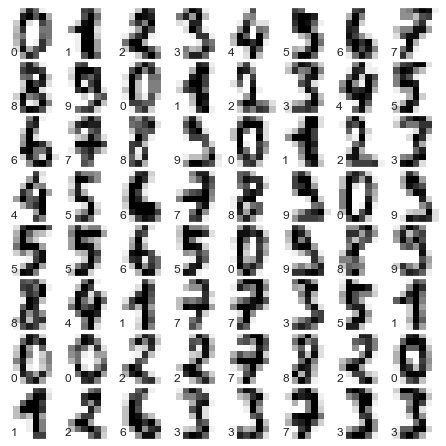

In [36]:
# set up the figure
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    
    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

Мы можем быстро классифицировать цифры, используя случайный лес, следующим образом:

In [37]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target,
                                                random_state=0)
model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

Мы можем взглянуть на отчет о классификации для этого классификатора:

In [38]:
from sklearn import metrics
print(metrics.classification_report(ypred, ytest))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        38
           1       0.98      0.95      0.97        44
           2       0.95      1.00      0.98        42
           3       0.98      0.98      0.98        45
           4       0.97      1.00      0.99        37
           5       0.98      0.96      0.97        49
           6       1.00      1.00      1.00        52
           7       1.00      0.96      0.98        50
           8       0.94      0.98      0.96        46
           9       0.98      0.98      0.98        47

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



И на всякий случай постройте матрицу путаницы:

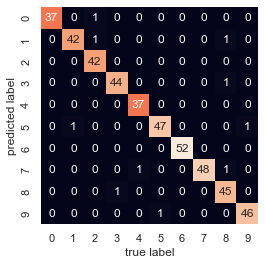

In [16]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

Мы обнаружили, что простой, ненастроенный случайный лес приводит к очень точной классификации цифровых данных.

## Резюме случайных лесов

Этот раздел содержал краткое введение в концепцию *ансамблевых оценок* и, в частности, случайного леса — ансамбля рандомизированных деревьев решений.
Случайные леса — это мощный метод с рядом преимуществ:

- И обучение, и прогнозирование выполняются очень быстро из-за простоты лежащих в их основе деревьев решений. Кроме того, обе задачи можно напрямую распараллелить, поскольку отдельные деревья являются полностью независимыми объектами.
- Множественные деревья допускают вероятностную классификацию: большинство голосов среди оценщиков дает оценку вероятности (доступ в Scikit-Learn с помощью метода predict_proba()).
- Непараметрическая модель чрезвычайно гибкая и поэтому может хорошо работать с задачами, которые не подходят другим оценщикам.

Основным недостатком случайных лесов является то, что результаты нелегко интерпретировать: то есть, если вы хотите сделать выводы о *значении* модели классификации, случайные леса могут быть не лучшим выбором.